# Recommendation Engine / System
## Proyecto: Recomendador de Medicamentos
### Usaremos Collaborative Filtering
### GRUPO 4

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from pylab import rcParams

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

import xgboost
from xgboost import XGBClassifier
from collections import Counter

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean

LABELS = ["1","2"]
#col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
#sns.set(style='white', font_scale=1.75, palette=sns.xkcd_palette(col_list))

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
'''
df_users = pd.read_csv("users.csv")
df_repos = pd.read_csv("repos-diabetes.csv")
df_ratings = pd.read_csv("ratings.csv")
'''
#df_repos = pd.read_csv("repos-dia-10.csv")
#df_repos = pd.read_csv("ratings.csv")
#df_repos = pd.read_csv("ratings-min.csv")

#'''
df_users = pd.read_csv("users-grupo-4.csv")
#df_repos = pd.read_csv("repos-diabetes.csv")
df_repos = pd.read_csv("repo-2022-10.csv")
#df_ratings = pd.read_csv("rating-min-10.csv")
#df_ratings = pd.read_csv("rating-cluster-4.csv")
df_ratings = pd.read_csv("grupo-4-E-2-med.csv")
#'''

#PROMEDIO SUMAR Y DIVIDIR PARA 5
#MSE 
#
#
#PRECISION 
#RECALL
#
#



In [3]:
df_users.head()

,userId,username,name
0,41,iris9112,Isabel Ruiz Buriticá
1,50,dianaclarke,Diana
2,55,nateprewitt,Nate Prewitt
3,81,oldani,Ordanis Sanchez
4,86,waflessnet,waflessnet


In [4]:
df_repos.head()

,repoId,title,categories,stars
0,1,Insulin degludec,"Diabetes, Type 1",12
1,2,Metformin,"Diabetes, Type 2",21
2,3,Glipizide,"Diabetes, Type 2",46
3,4,Glyburide,"Diabetes, Type 2",2
4,5,Pioglitazone,"Diabetes, Type 2",23


In [5]:
df_ratings.head()

,userId,repoId,rating
0,55,2,2
1,86,2,1
2,145,2,1
3,155,2,2
4,235,2,2


In [6]:
n_users = df_ratings.userId.unique().shape[0]
n_items = df_ratings.repoId.unique().shape[0]
print (str(n_users) + ' users')
print (str(n_items) + ' items')

646 users
9 items


(array([284.,   0.,   0.,   0.,   0.,   0.,   0., 403.]),
 array([1.   , 1.125, 1.25 , 1.375, 1.5  , 1.625, 1.75 , 1.875, 2.   ]),
 <BarContainer object of 8 artists>)

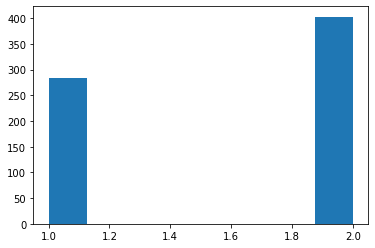

In [7]:
plt.hist(df_ratings.rating,bins=8)

In [8]:
df_ratings.groupby(["rating"])["userId"].count()

rating
1    284
2    403
Name: userId, dtype: int64

(array([4., 1., 1., 0., 1., 1., 0., 1.]),
 array([  1.  ,  29.75,  58.5 ,  87.25, 116.  , 144.75, 173.5 , 202.25,
        231.  ]),
 <BarContainer object of 8 artists>)

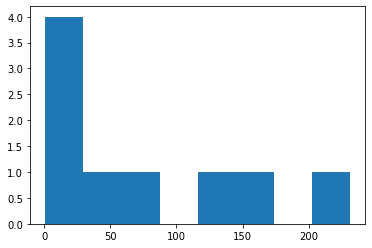

In [9]:
plt.hist(df_ratings.groupby(["repoId"])["repoId"].count(),bins=8)

# Método 1: User-Based

In [10]:
df_matrix = pd.pivot_table(df_ratings, values='rating', index='userId', columns='repoId').fillna(0)
df_matrix

repoId,2,3,4,5,6,7,8,9,10
userId,,,,,,,,,
41,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
86,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
5127,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5128,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5143,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
ratings = df_matrix.values
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 11.82%


In [12]:
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.2, shuffle=False, random_state=42)

In [13]:
ratings_train.shape

(516, 9)

### IMPORTANTE ratings_train.shape value

# 6457

In [14]:
ratings_test.shape

(130, 9)

<ul>
<li>Matriz de similitud entre los usuarios (distancia del coseno -vectores-).</li>
<li>Predecir la valoración desconocida de un ítem i para un usuario activo u basandonos en la suma ponderada de todas las valoraciones del resto de usuarios para dicho ítem.</li>
<li>Recomendaremos los nuevos ítems a los usuarios según lo establecido en los pasos anteriores.</li>
</ul>

In [15]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings)

In [16]:
sim_matrix.shape

(646, 646)

### IMPORTANTE sim_matrix.shape value

### 8072

In [17]:
# sim_matrix

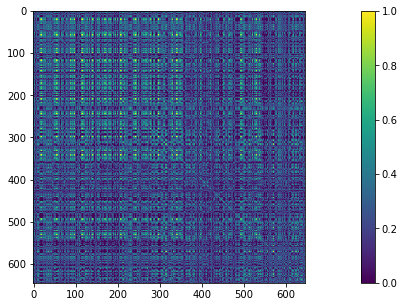

In [18]:
plt.rcParams['figure.figsize'] = (20.0, 5.0)
plt.imshow(sim_matrix);
plt.colorbar()
plt.show()

In [19]:
#separar las filas y columnas de train y test
#ratings_train =80
#ratings_test =20
'''
sim_matrix_train = sim_matrix[0:24,0:24]
sim_matrix_test = sim_matrix[24:30,24:30]


80  -> 1108
100 -> 1386
'''
sim_matrix_train = sim_matrix[0:516,0:516]
sim_matrix_test = sim_matrix[516:646,516:646]
print(sim_matrix_train.shape)
print(sim_matrix_test.shape)

(516, 516)
(130, 130)


## Predicciones (las recomendaciones!)

In [20]:
users_predictions = sim_matrix_train.dot(ratings_train) / np.array([np.abs(sim_matrix_train).sum(axis=1)]).T

In [21]:
users_predictions.shape

(516, 9)

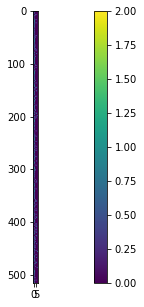

In [22]:
plt.rcParams['figure.figsize'] = (20.0, 5.0)
plt.imshow(users_predictions);
plt.colorbar()
plt.show()

### Veamos un ejemplo

In [23]:
USUARIO_EJEMPLO = 'jbagnato' # debe existir en nuestro dataset de train!
data = df_users[df_users['username'] == USUARIO_EJEMPLO]
usuario_ver = data.iloc[0]['userId'] -1 # resta 1 para obtener el index de pandas
user0=users_predictions.argsort()[usuario_ver]

# Veamos los tres recomendados con mayor puntaje en la predic para este usuario
for i, aRepo in enumerate(user0[-3:]):
    selRepo = df_repos[df_repos['repoId']==(aRepo+1)]
    print(selRepo['title'] , 'puntaje:', users_predictions[usuario_ver][aRepo])

0    Insulin degludec
Name: title, dtype: object puntaje: 0.029893345905784966
1    Metformin
Name: title, dtype: object puntaje: 0.029893345905784966
5    Rosiglitazone
Name: title, dtype: object puntaje: 1.7674843363743076


## Medir el Error

In [24]:
def get_mse(preds, actuals):
    if preds.shape[1] != actuals.shape[1]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)


MSE de ratings_train

In [25]:
get_mse(users_predictions, ratings_train)

0.3213797962970113

MSE de ratings_test

In [26]:
# Realizo las predicciones para el test set
users_predictions_test = sim_matrix.dot(ratings) / np.array([np.abs(sim_matrix).sum(axis=1)]).T

#MODIFICAR CON TAMAÑO DE LA MATRIZ
# 80  -> 1108
# 100 -> 1386

users_predictions_test = users_predictions_test[516:646,:]

'''
users_predictions_test = users_predictions_test[24:30,:]
'''
get_mse(users_predictions_test, ratings_test)

0.33054035220421213

In [27]:
#lets extract features and targets
X=df_ratings.drop(columns=['rating'])
y=df_ratings['rating']

In [28]:
#ratings_train, ratings_test = train_test_split(ratings, test_size = 0.2, shuffle=False, random_state=42)

train_X,test_X,train_y,test_y=train_test_split(X,y,test_size=0.2, shuffle=False, random_state=42)

In [29]:
train_X.shape,test_X.shape,train_y.shape,test_y.shape

((549, 2), (138, 2), (549,), (138,))

In [30]:
from sklearn.metrics import confusion_matrix,accuracy_score,make_scorer
from sklearn.model_selection import cross_validate

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

#cross validation purpose
scoring = {'accuracy': make_scorer(accuracy_score),'prec': 'precision'}
scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
           'fp': make_scorer(fp), 'fn': make_scorer(fn)}

def display_result(result):
    print("TP: ",result['test_tp'])
    print("TN: ",result['test_tn'])
    print("FN: ",result['test_fn'])
    print("FP: ",result['test_fp'])

In [31]:
def run_model(train_X, test_X, train_y, test_y):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
    clf_base.fit(train_X, train_y)
    #clf_base.fit(X_train, y_train)
    return clf_base

In [32]:
#modelo
model = run_model(train_X, test_X, train_y, test_y)
#model = run_model(X_train, X_test, y_train, y_test)

In [33]:
#def mostrar_resultados(y_test, pred_y):
def mostrar_resultados(test_y, pred_y):
#   conf_matrix = confusion_matrix(y_test, pred_y)
    conf_matrix = confusion_matrix(test_y, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    #sns.heatmap(conf_matrix, annot=True, fmt='g')
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(test_y, pred_y))

In [34]:
"""
pred_y = model.predict(test_X)
mostrar_resultados(test_y, pred_y)
"""

'\npred_y = model.predict(test_X)\nmostrar_resultados(test_y, pred_y)\n'

In [35]:
X_train = train_X 
y_train = train_y
X_test = test_X
y_test = test_y

classifier = XGBClassifier()
classifier.fit(X_train, y_train)

[18:23:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=20,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
y_pred = classifier.predict(X_test)

In [37]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[24 26]
 [40 48]]


0.5217391304347826

In [38]:
from sklearn.metrics import roc_auc_score

acc=[]
roc=[]

In [39]:
#find accuracy
ac=accuracy_score(y_test, y_pred)
acc.append(ac)

#find the ROC_AOC curve
rc=roc_auc_score(y_test, y_pred)
roc.append(rc)
print("\nAccuracy {0} ROC {1}".format(ac,rc))

#cross val score
#result=cross_validate(clf,train_X,train_y,scoring=scoring,cv=10)
#display_result(result)



Accuracy 0.5217391304347826 ROC 0.5127272727272727


# Resultados métricas Accuracy y ROC

<AxesSubplot:>

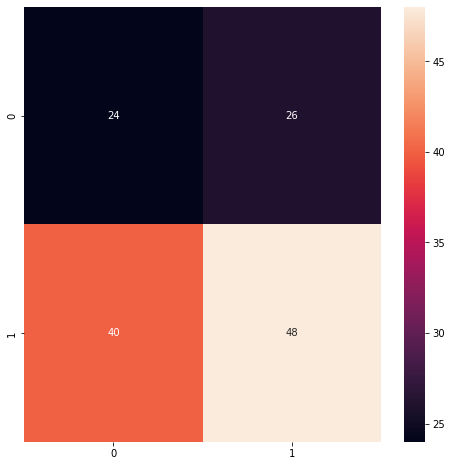

In [40]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g')